# Lofi MNIST bandit

In [16]:
import os
import jax
import pandas as pd
import numpy as np
import flax.linen as nn
import matplotlib.pyplot as plt

from bayes_opt import BayesianOptimization
from bandits.environments.mnist_env import MnistEnvironment
from bandits.agents.low_rank_filter_bandit import LowRankFilterBandit

import lofi_tabular as experiment

In [3]:
%config InlineBackend.figure_format = "retina"

In [9]:
class MLP(nn.Module):
    num_arms: int

    @nn.compact
    def __call__(self, x):
        # x = nn.Dense(200)(x)
        # x = nn.elu(x)
        # x = nn.Dense(200)(x)
        # x = nn.elu(x)
        x = nn.Dense(200, name="last_layer")(x)
        x = nn.elu(x)
        x = nn.Dense(self.num_arms)(x)
        return x

In [10]:
ntrials = 1
npulls = 20
key = jax.random.PRNGKey(314)
key_env, key_train, key_eval = jax.random.split(key, 3)

n_warmup = 500
n_test = 8_000
env = MnistEnvironment(key, ntrain=n_warmup)
env_test = MnistEnvironment(key, ntrain=n_test)

num_arms = env.labels_onehot.shape[-1]
model = MLP(num_arms)

## LoFi

In [18]:
name_agent = "lofi-fixed"
extra_params = {
    "memory_size": 15,
    "model": model,
    "dynamics_weights": 1.0,
    "dynamics_covariance": 0.0,

}

@jax.jit
def bbf(**heval):
    res = experiment.warmup_and_run(
        heval, 
        experiment.transform_hparams_lofi_fixed,
        LowRankFilterBandit,
        env,
        key_train,
        npulls,
        **extra_params,
    )

    
    return res["hist_train"]["rewards"].sum()

In [21]:
%%time
# try q=0, γ=1
pbounds = {
    "log_em_cov": [-10, 0], # empirical covariance
    "log_init_cov": [-10, 0],
}


optimiser = BayesianOptimization(
    f=bbf,
    pbounds=pbounds,
    random_state=2718,
)

# LoFi
optimiser.maximize(init_points=5, n_iter=15)

|   iter    |  target   | log_em... | log_in... |
-------------------------------------------------
| 1         | 67.0      | -5.738    | -2.971    |
| 2         | 57.0      | -1.514    | -9.956    |
| 3         | 167.0     | -9.159    | -9.927    |
| 4         | 77.0      | -4.961    | -5.19     |
| 5         | 53.0      | -1.243    | -1.285    |
| 6         | 164.0     | -9.99     | -7.321    |
| 7         | 175.0     | -10.0     | -10.0     |
| 8         | 157.0     | -10.0     | -9.101    |
| 9         | 150.0     | -9.989    | -3.937    |
| 10        | 44.0      | -10.0     | 0.0       |
| 11        | 150.0     | -8.596    | -5.863    |
| 12        | 154.0     | -9.999    | -5.726    |
| 13        | 157.0     | -6.286    | -10.0     |
| 14        | 152.0     | -7.232    | -8.091    |
| 15        | 165.0     | -7.615    | -10.0     |
| 16        | 185.0     | -8.89     | -7.47     |
| 17        | 46.0      | 0.0       | -5.695    |
| 18        | 156.0     | -8.599    | -8.196    |


# Agents

In [33]:
name = "LoFi"

In [ ]:
%%time
res = experiment.warmup_and_run(
    optimiser.max["params"], 
    experiment.transform_hparams_lofi_fixed,
    LowRankFilterBandit,
    env_test,
    key_eval,
    npulls,
    n_trials=8,
    **extra_params,
)

res = jax.tree_map(np.array, res)

LoFi - 6395.12±33.72


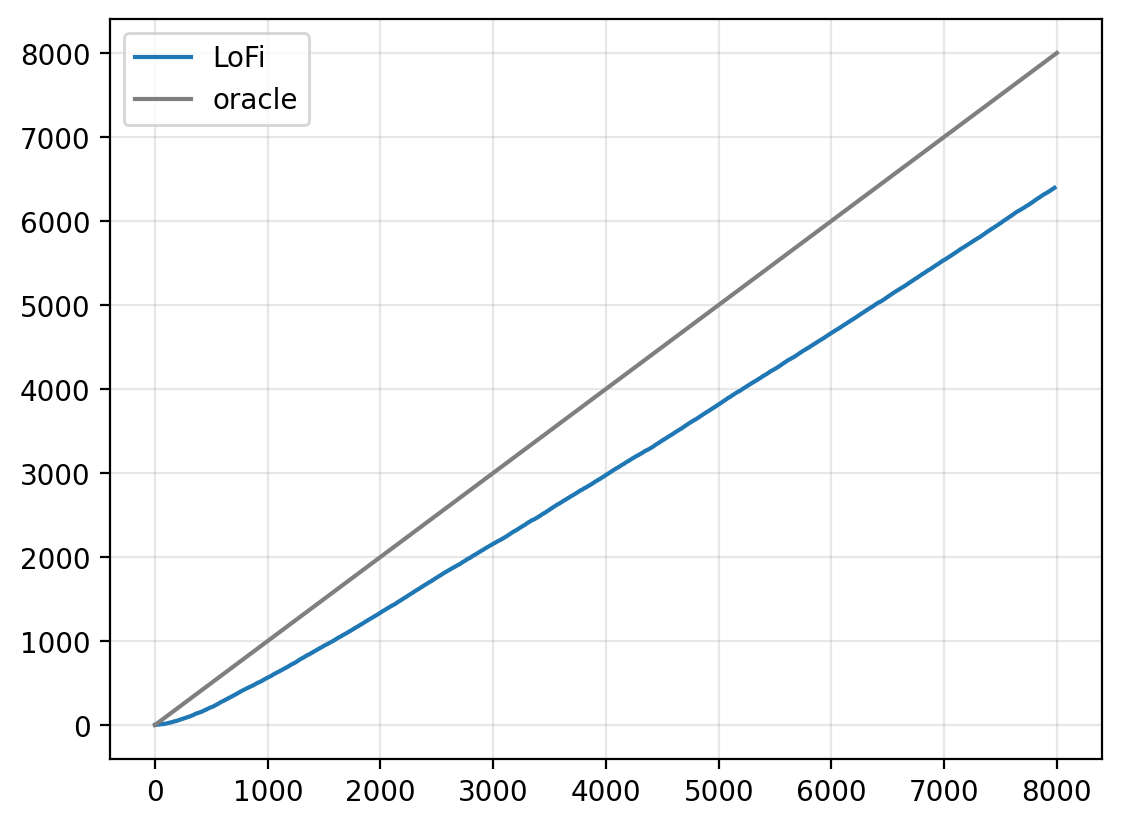

In [34]:
rewards = res["hist_train"]["rewards"]
mean_reward = rewards.sum(axis=1).mean()
std_reward = rewards.sum(axis=1).std()

rewards = pd.DataFrame(rewards).T.cumsum(axis=0)
print(f"{name} - {mean_reward:0.2f}±{std_reward:0.2f}")

nsteps = len(rewards)
rewards.mean(axis=1).plot(label=name)
plt.plot([0, n_test], [0, n_test], c="tab:gray", label="oracle")
plt.legend()
plt.grid(alpha=0.3)